In [291]:
from typing import Iterable

import numpy as np
import sympy as sy


class NewtonInterpolation:

    def __init__(self):
        pass

    def __get_divided_differential__(self, X: Iterable, Y: Iterable):
        num_obs = len(X)
        res = np.zeros(shape=(num_obs, num_obs))

        res[:, 0] = Y
        for id_y in range(1, num_obs):
            for id_x in range(0, num_obs - id_y):
                differential = res[id_x + 1][id_y - 1] - res[id_x][id_y - 1]
                divided = X[id_x + id_y] - X[id_x]
                res[id_x][id_y] = differential / divided
        return res

    def fit(self, X: Iterable, Y: Iterable, method: str = 'forward'):
        assert len(X) == len(Y)

        x_var = sy.Symbol('x')

        divided_differential = self.__get_divided_differential__(X=X, Y=Y)

        res = 0
        term_list = []
        term = 1

        if method == 'forward':
            r = divided_differential[0]
        elif method == 'backward':
            r = np.fliplr(divided_differential).diagonal()

        for _, (obs, coef) in enumerate(zip(X, r)):
            res += coef * term
            term_list.append(coef * term)
            term *= (x_var - obs)
        self.res = res
        self.term_list = term_list
        return res

    def add_points(self, X: Iterable, Y: Iterable):
        pass

    def eval(self, val):
        return self.res.subs({'x': val})


In [376]:
from typing import Dict, Iterable, Tuple

import numpy as np

from module import LagrangeInterpolation


class InverseInterpolation:

    def __init__(self, config: Dict) -> None:
        self.method = config['method']
        self.config = config[self.method]
        if config.get('method', False) == 'inverse_function':
            if config['inverse_function']['type'] == 'lagrange':
                self.interpolator = LagrangeInterpolation()
            elif config['inverse_function']['type'] == 'newton':
                self.interpolator = NewtonInterpolation()
        elif config.get('method', False) == 'iterative':
            self.interpolator = NewtonInterpolation()

    def __get_monotonic_sequences__(self, Y: Iterable):
        """Xác định các chuỗi đơn điệu

        Args:
            Y (Iterable): Y

        Returns:
            [List[Tuple]]: Các khoảng đơn điệu, gồm điểm đầu và điểm cuối
        """
        indices = [0]
        diff = np.diff(Y)
        for idx in range(1, len(diff)):
            if diff[idx - 1] * diff[idx] < 0:
                indices.append(idx)
        indices.append(len(diff))
        return list(zip(indices, indices[1:]))

    def __get_isolation_interval__(self, Y: Iterable, target: float):
        """Tìm khoảng phân ly nghiệm

        Args:
            Y (Iterable): Y
            target (float): Giá trị cần tính

        Returns:
            [List[Tuple]]: Tập các khoảng phân ly nghiệm
        """
        indices = []
        diff = list(map(lambda ref: target - ref, Y))
        for index in range(1, len(Y)):
            if diff[index - 1] * diff[index] < 0:
                indices.append((index - 1, index))
        return indices

    def __get_divided_differential__(self, X: Iterable, Y: Iterable):
        """Bảng tỉ hiệu
        """
        num_obs = len(X)
        res = np.zeros(shape=(num_obs, num_obs))

        res[:, 0] = Y
        for id_y in range(1, num_obs):
            for id_x in range(0, num_obs - id_y):
                differential = res[id_x + 1][id_y - 1] - res[id_x][id_y - 1]
                divided = X[id_x + id_y] - X[id_x]
                res[id_x][id_y] = differential / divided
        return res

    def __get_containing_monotonic_seq__(self, monotonic_seq: Iterable,
                                         isolation_interval: Iterable):
        """Xác định khoảng đơn điệu chứa khoảng phân ly nghiệm

        Args:
            monotonic_seq (Iterable): Các khoảng đơn điệu
            isolation_interval (Iterable): Các khoảng phân ly nghiệm

        Returns:
            [Dict]: {Khoảng phân ly: Khoảng chứa}
        """
        res = {}
        for interval in isolation_interval:
            out = list(
                filter(
                    lambda s: (interval[0] - s[0]) * (interval[1] - s[1]) <= 0,
                    monotonic_seq))[0]
            res[interval] = out
        return res

    def __forward_or_backward__(self, isolation_interval: Tuple,
                                containing_monotonic_sequence: Tuple):
        """Newton tiến or lùi?

        Args:
            isolation_interval (Tuple): Các khoảng phân ly nghiệm
            containing_monotonic_sequence (Tuple): Khoảng đơn điệu

        Returns:
            [str]: tiến/lùi
        """
        if containing_monotonic_sequence[1] - isolation_interval[
                0] > isolation_interval[1] - containing_monotonic_sequence[0]:
            return 'forward'
        return 'backward'

    def __fit_inverse_function__(self, X: Iterable, Y: Iterable, target: float):
        """Phương pháp dùng hàm ngược

        Args:
            X (Iterable): X
            Y (Iterable): Y
            target (float): Giá trị cần tính ngược

        Returns:
            (List): Tập nghiệm
        """
        monotonic_seq = self.__get_monotonic_sequences__(Y=Y)
        isolation_interval = self.__get_isolation_interval__(Y=Y, target=target)
        containing_seq = self.__get_containing_monotonic_seq__(
            monotonic_seq=monotonic_seq, isolation_interval=isolation_interval)

        res = []
        for seq in containing_seq.values():
            self.interpolator.fit(X=Y[seq[0]:seq[1] + 1],
                                  Y=X[seq[0]:seq[1] + 1])
            res.append(self.interpolator.eval(target))
        self.res = res
        return res

    def __fit_iterative__(self, X: Iterable, Y: Iterable, target: float):
        """Phương pháp lặp

        Args:
            X (Iterable): X
            Y (Iterable): Y
            target (float): Giá trị cần tính

        Returns:
            [List]: Tập nghiệm
        """
        h = X[1] - X[0]

        monotonic_seq = self.__get_monotonic_sequences__(Y=Y)
        isolation_interval = self.__get_isolation_interval__(Y=Y, target=target)
        containing_seq = self.__get_containing_monotonic_seq__(
            monotonic_seq=monotonic_seq, isolation_interval=isolation_interval)
        """Note nhẹ
        """
        output = []
        print(containing_seq)
        for case in containing_seq.items():
            interval = case[0]
            seq = case[1]
            method = self.__forward_or_backward__(
                isolation_interval=interval, containing_monotonic_sequence=seq)

            if method == 'forward':
                x = X[interval[0]:seq[1] + 1]
                y = Y[interval[0]:seq[1] + 1]
                u = (target - y[0]) / h
                self.interpolator.fit(X=x, Y=y, method=method)
                term_list = self.interpolator.term_list
                phi_u = sum(term_list) - term_list[1]
                phi_u = target - y[0] - phi_u/h
                for ite in range(self.config['max_ite']):
                    u_old = u
                    u = phi_u.subs({"x": u})
                    tol = np.abs(u - u_old)
                    if tol < float(self.config['tolerance']):
                        break
                x = x[0] + u*h
                output.append({
                    'root': x,
                    'iteration': ite + 1,
                    'tol': tol,
                    'isConvergence': bool(tol < 1e-4)
                })

            elif method == 'backward':
                x = X[seq[0]:interval[1] + 1]
                y = Y[seq[0]:interval[1] + 1]
                u = (target - y[-1]) / h
                self.interpolator.fit(X=x, Y=y, method=method)
                term_list = self.interpolator.term_list
                phi_u = sum(term_list) - term_list[1]
                phi_u = target - y[-1] - phi_u/h

                for ite in range(self.config['max_ite']):
                    u_old = u
                    u = phi_u.subs({"x": u})
                    tol = np.abs(u - u_old)
                    if tol < float(self.config['tolerance']):
                        break
                x = x[-1] + u*h
                output.append({
                    'root': u,
                    'iteration': ite + 1,
                    'tol': tol,
                    'isConvergence': bool(tol < 1e-4)
                })

        return output

    def fit(self, X: Iterable, Y: Iterable, target: float):
        assert len(X) == len(Y)

        monotonic_seq = self.__get_monotonic_sequences__(Y=Y)
        isolation_intervals = self.__get_isolation_interval__(Y=Y)

        containing_seq = self.__get_containing_monotonic_seq__(
            monotonic_seq=monotonic_seq, isolation_interval=isolation_intervals)

        res = 0
        # Statements here
        self.res = res
        return res

    def eval(self, val):
        return self.res.subs({'x': val})


{'method': 'iterative',
 'inverse_function': {'type': 'lagrange'},
 'iterative': {'type': 'auto', 'max_ite': 100, 'tolerance': '1e-6'}}

In [377]:
config = {
    "method": "iterative",
    "inverse_function": {
        "type": "lagrange"
    },
    "iterative": {
        "type": "auto",
        "max_ite": 100,
        "tolerance": 0.000001
    }
}

In [41]:
client = InverseInterpolation(config)

In [42]:
x = np.array([1,2,3,4,5,6,7])/4
y = x**3  - x**2 - 1

In [43]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y)
)

fig.write_image("poly_xy.png")

Forward
Forward


In [44]:
target = -0.5

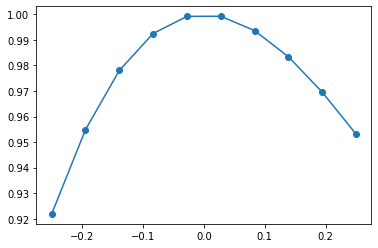

In [45]:
print(client.__fit_inverse_function__(x, y, target))
print(client.__fit_iterative__(x, y, target, 'backward'))
print(client.__fit_iterative__(x, y, target))

In [378]:
import matplotlib.pyplot as plt
import numpy as np

from utils.helpers import load_config

config = load_config('config.yml')
config

{'method': 'iterative',
 'inverse_function': {'type': 'lagrange'},
 'iterative': {'type': 'auto', 'max_ite': 100, 'tolerance': '1e-6'}}

In [379]:
target = 4.5

In [380]:
client.__fit_iterative__(observations, references, val)

{(2, 3): (0, 5), (6, 7): (5, 9)}
-1.41666666666667*x - 0.354166666666667
-17.8645833333333*(x + 0.138888888888889)*(x + 0.194444444444444)*(x + 0.25) - 4.68055555555555*(x + 0.194444444444444)*(x + 0.25) - 18.0074768518532
0.0153677983539095 - 0.184413580246914*x
-17.9999999999973*(x - 0.194444444444444)*(x - 0.138888888888889)*(x - 0.0833333333333333) + 10.4999999999998*(x - 0.138888888888889)*(x - 0.0833333333333333) - 17.8940509259259


[{'root': 5.00912918709353e+322175111801781151797147740875412035165636017771,
  'iteration': 100,
  'tol': 5.00912918709353e+322175111801781151797147740875412035165636017771,
  'isConvergence': False},
 {'root': 5.56805109781082e+319393809493912665084209857242650847239252717733,
  'iteration': 100,
  'tol': 1.00224919760595e+319393809493912665084209857242650847239252717735,
  'isConvergence': False}]